In [10]:
# =========================================================
# 1) OPTIONAL INSTALLS (Colab-only)
# =========================================================
# If running in Google Colab, uncomment to install dependencies.
# Local Jupyter users should keep this commented out.
# !pip install scikit-learn statsmodels pandas matplotlib


# =========================================================
# 2) CORE PYTHON / GENERAL UTILITIES
# =========================================================
import os                         # Directory and file-handling utilities
import numpy as np                # Numerical arrays and vectorized operations
import pandas as pd               # DataFrames for loading, cleaning, and analyzing data
import matplotlib.pyplot as plt   # Plotting library (EDA, ROC curves, confusion matrices)


# =========================================================
# 3) SCIKIT-LEARN COMPONENTS
# =========================================================
from sklearn.model_selection import train_test_split   # Split dataset into train/test sets

# Preprocessing utilities
from sklearn.compose import ColumnTransformer          # Apply different transforms to numeric vs categorical features
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Encode categorical + scale numeric features

from sklearn.pipeline import Pipeline                  # Combine preprocessing + model steps
from sklearn.impute import SimpleImputer               # Handle missing values


# =========================================================
# 4) EVALUATION METRICS AND VISUALIZATION TOOLS
# =========================================================
from sklearn.metrics import (
    accuracy_score,             # Overall correctness
    precision_score,            # TP / (TP + FP)
    recall_score,               # TP / (TP + FN)
    f1_score,                   # Harmonic mean of precision and recall
    roc_auc_score,              # Area under ROC curve
    roc_curve,                  # Points for ROC plotting
    ConfusionMatrixDisplay,     # Utility for plotting confusion matrices
    classification_report       # Detailed per-class performance summary
)


# =========================================================
# 5) MODELS
# =========================================================
from sklearn.linear_model import LogisticRegression    # Logistic Regression classifier
from sklearn.naive_bayes import GaussianNB             # Gaussian Naive Bayes classifier


# =========================================================
# 6) STATS MODELS (FOR AIC/BIC COMPUTATION)
# =========================================================
import statsmodels.api as sm    # Used to compute AIC/BIC based on Logit likelihood


# =========================================================
# 7) PROJECT CONFIGURATION
# =========================================================
DATA_PATH = "titanic (1).csv"   # Input CSV file containing the Titanic dataset
OUT_DIR   = "titanic_outputs"   # Directory to store plots and results files
os.makedirs(OUT_DIR, exist_ok=True)  # Ensure output directory exists


# =========================================================
# 8) GLOBAL VISUAL SETTINGS
# =========================================================
plt.rcParams["figure.figsize"] = (10, 6)  # Consistent plot sizing for readability

# Global random seed for reproducibility across runs
GLOBAL_RANDOM_SEED = 42


In [16]:
# =========================================================
# 📌 STEP 1 — DATA COLLECTION
#     Load dataset, validate columns, create binary target,
#     inspect structure, and save a preview.
# =========================================================

# Load CSV and normalize all column names to lowercase
df = pd.read_csv(DATA_PATH).rename(columns=str.lower)

# Required columns expected in the Titanic dataset
expected = [
    'age', 'portembarked', 'fare', 'numparentschildren',
    'passengerclass', 'sex', 'numsiblings', 'survived'
]

# Check if any expected column is missing
missing = [c for c in expected if c not in df.columns]
assert not missing, (
    f"Missing expected columns: {missing}\n"
    f"Found columns: {df.columns.tolist()}"
)

# Convert 'survived' from {1,2} to standard binary {0,1}
# 1 = did not survive → 0
# 2 = survived        → 1
df['survived_bin'] = df['survived'].map({1: 0, 2: 1}).astype(int)

# Display structural information about the dataset
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())
print("\nBinary target counts:\n", df['survived_bin'].value_counts())

# Save a preview (first 20 rows) to the output folder
df.head(20).to_csv(os.path.join(OUT_DIR, "preview_head20.csv"), index=False)
print("\nSaved preview_head20.csv in:", OUT_DIR)


Shape: (889, 9)
Columns: ['age', 'portembarked', 'fare', 'numparentschildren', 'passengerclass', 'sex', 'numsiblings', 'survived', 'survived_bin']

Missing values per column:
 age                   0
portembarked          0
fare                  0
numparentschildren    0
passengerclass        0
sex                   0
numsiblings           0
survived              0
survived_bin          0
dtype: int64

Binary target counts:
 survived_bin
0    549
1    340
Name: count, dtype: int64

Saved preview_head20.csv in: titanic_outputs


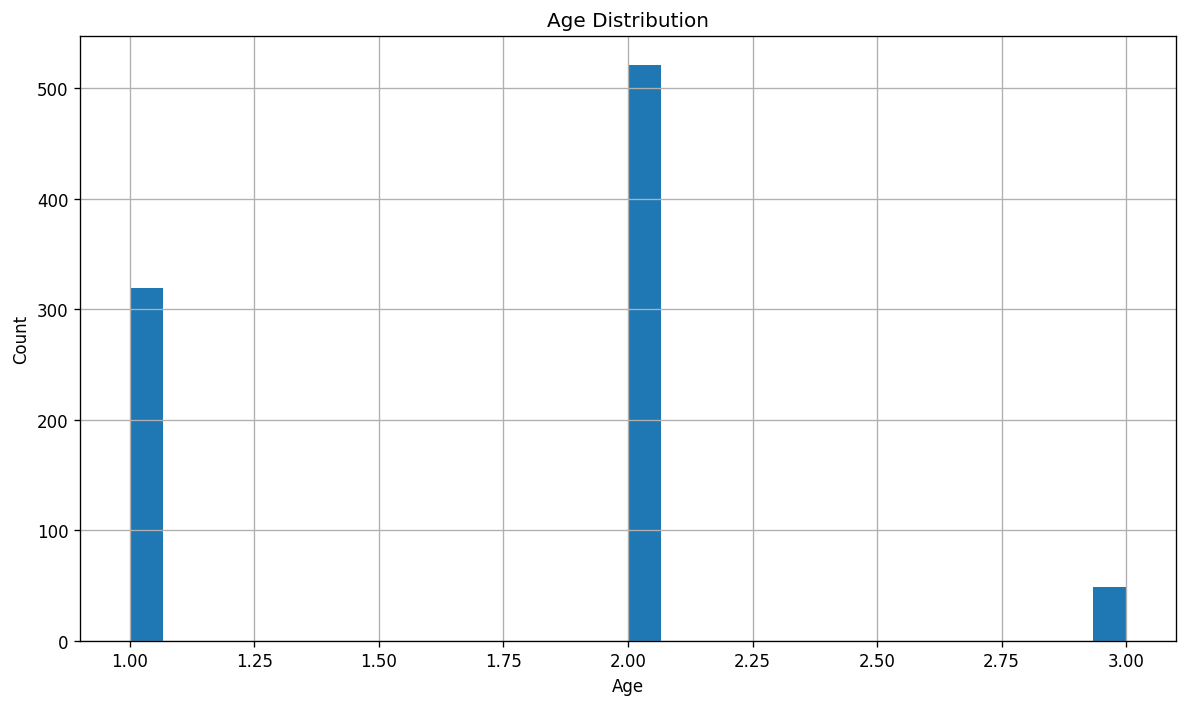

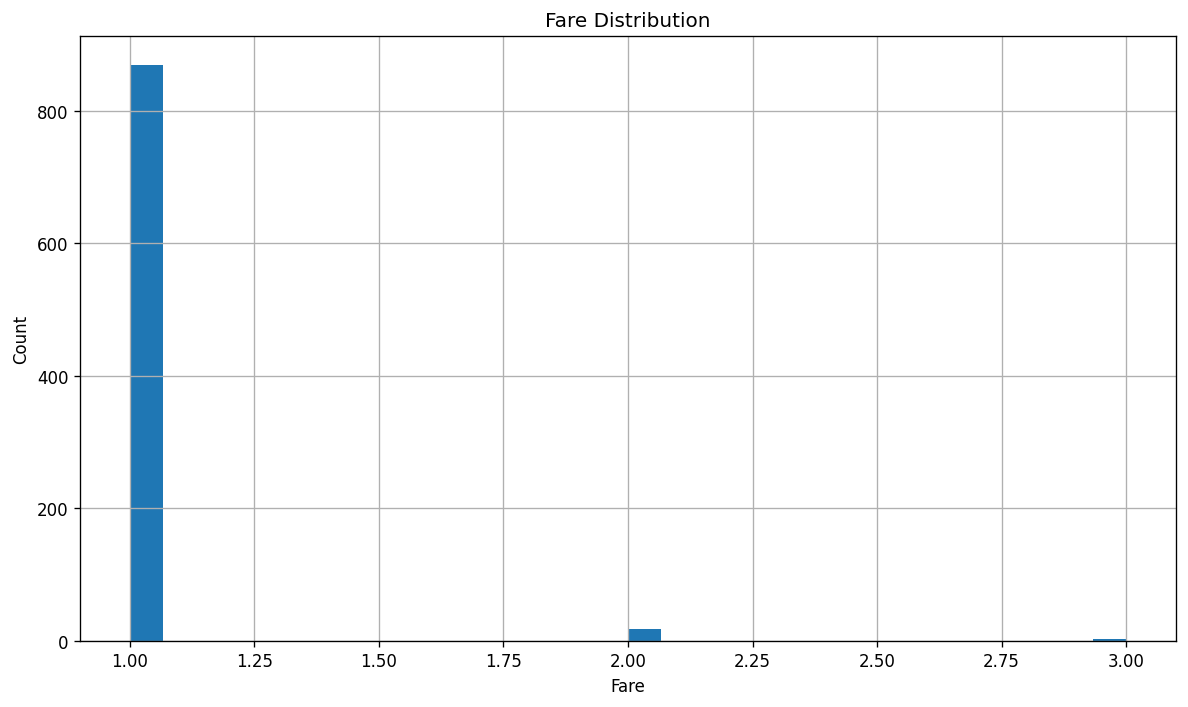

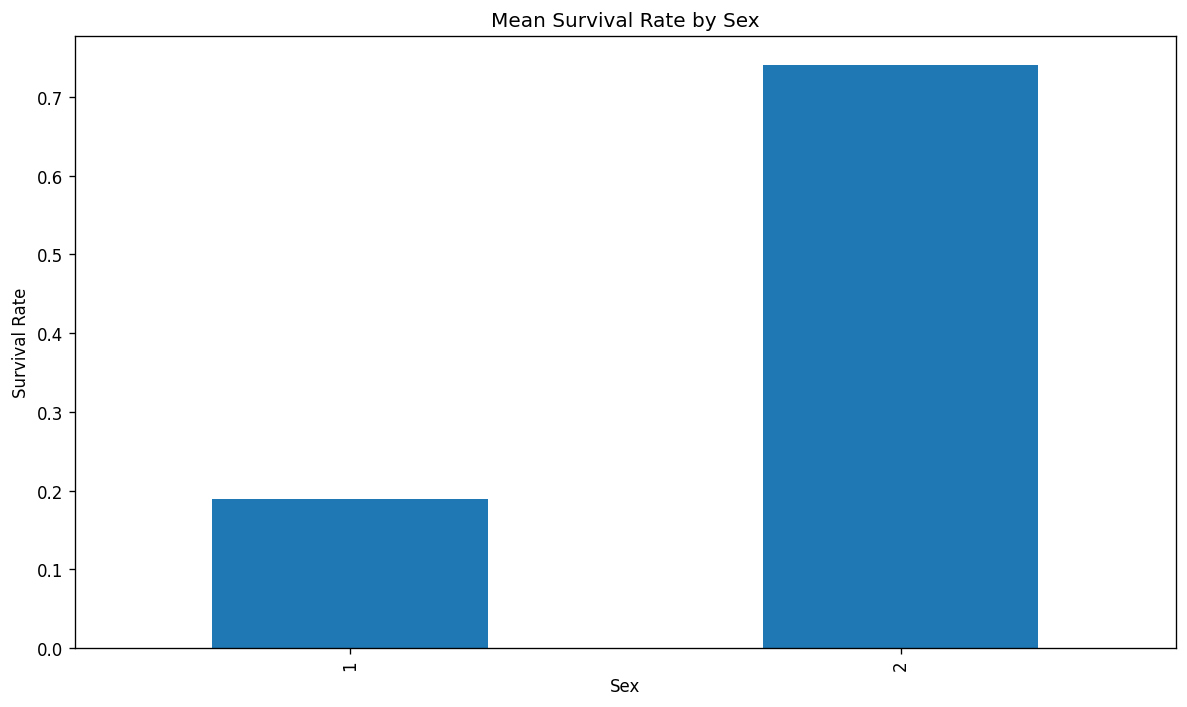

In [17]:
# =========================================================
# 📌 STEP 2 — OBSERVE DATA & FORMULATE HYPOTHESIS (EDA)
#     Visualize key distributions and group statistics to
#     understand patterns before modeling.
# =========================================================

# ---------------------------------------------------------
# Age distribution — helps identify young/old passenger trends
# ---------------------------------------------------------
df['age'].hist(bins=30)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_age_hist.png"))
plt.show()

# ---------------------------------------------------------
# Fare distribution — indicates socio-economic differences
# ---------------------------------------------------------
df['fare'].hist(bins=30)
plt.title("Fare Distribution")
plt.xlabel("Fare")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_fare_hist.png"))
plt.show()

# ---------------------------------------------------------
# Mean survival rate by sex — strong categorical signal
# ---------------------------------------------------------
df.groupby('sex')['survived_bin'].mean().plot(kind='bar')
plt.title("Mean Survival Rate by Sex")
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "eda_survival_by_sex.png"))
plt.show()

# ---------------------------------------------------------
# Hypothesis formulation (conceptual, not code):
# ---------------------------------------------------------
# H1: Sex is a strong predictor of survival probability.
# H2: Higher fare (proxy for travel class) increases survival odds.
# H3: Family size (numsiblings + numparentschildren) may affect survival.


In [18]:
# =========================================================
# 📌 STEP 3 — CONSTRUCT MODEL
#     Define feature sets, create preprocessing pipelines,
#     and build two supervised learning models:
#     (1) Logistic Regression, (2) Gaussian Naive Bayes.
# =========================================================

# ---------------------------------------------------------
# Feature groups and target column
# ---------------------------------------------------------
num_features = ['age', 'fare', 'numparentschildren', 'numsiblings']       # Numeric predictors
cat_features = ['sex', 'portembarked', 'passengerclass']                  # Categorical predictors
target       = 'survived_bin'                                             # Binary target (0/1)

# Input matrix (X) and output vector (y)
X = df[num_features + cat_features].copy()
y = df[target].copy()

# ---------------------------------------------------------
# Train/test split
# ---------------------------------------------------------
# - test_size = 20% of data
# - random_state ensures reproducibility
# - stratify preserves class distribution between train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# ---------------------------------------------------------
# Preprocessing for numeric features:
# ---------------------------------------------------------
# 1) Impute missing values with median
# 2) Scale to zero mean, unit variance
numeric_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# ---------------------------------------------------------
# Preprocessing for categorical features:
# ---------------------------------------------------------
# 1) Impute missing values with most frequent category
# 2) Apply one-hot encoding (dense output for compatibility)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

categorical_tf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  ohe)
])

# ---------------------------------------------------------
# Combine preprocessing into a single transformer:
# ---------------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_features),   # apply numeric pipeline
        ('cat', categorical_tf, cat_features) # apply categorical pipeline
    ]
)

# ---------------------------------------------------------
# Model A — Logistic Regression
# ---------------------------------------------------------
# Classic linear classifier covered in lectures.
# - solver='lbfgs' is robust for small/medium datasets
# - max_iter increased to avoid convergence warnings
logreg_clf = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=500, solver='lbfgs'))
])

# ---------------------------------------------------------
# Model B — Gaussian Naive Bayes
# ---------------------------------------------------------
# Probabilistic classifier assuming normally distributed features.
# Covered in Naive Bayes lecture.
gnb_clf = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', GaussianNB())
])


LogReg (test): {'accuracy': 0.8089887640449438, 'precision': 0.7931034482758621, 'recall': 0.6764705882352942, 'f1': 0.7301587301587301, 'roc_auc': 0.8513368983957218}
GNB    (test): {'accuracy': 0.797752808988764, 'precision': 0.7424242424242424, 'recall': 0.7205882352941176, 'f1': 0.7313432835820896, 'roc_auc': 0.8282085561497325}

Classification report (LogReg):
               precision    recall  f1-score   support

           0      0.817     0.891     0.852       110
           1      0.793     0.676     0.730        68

    accuracy                          0.809       178
   macro avg      0.805     0.784     0.791       178
weighted avg      0.808     0.809     0.806       178



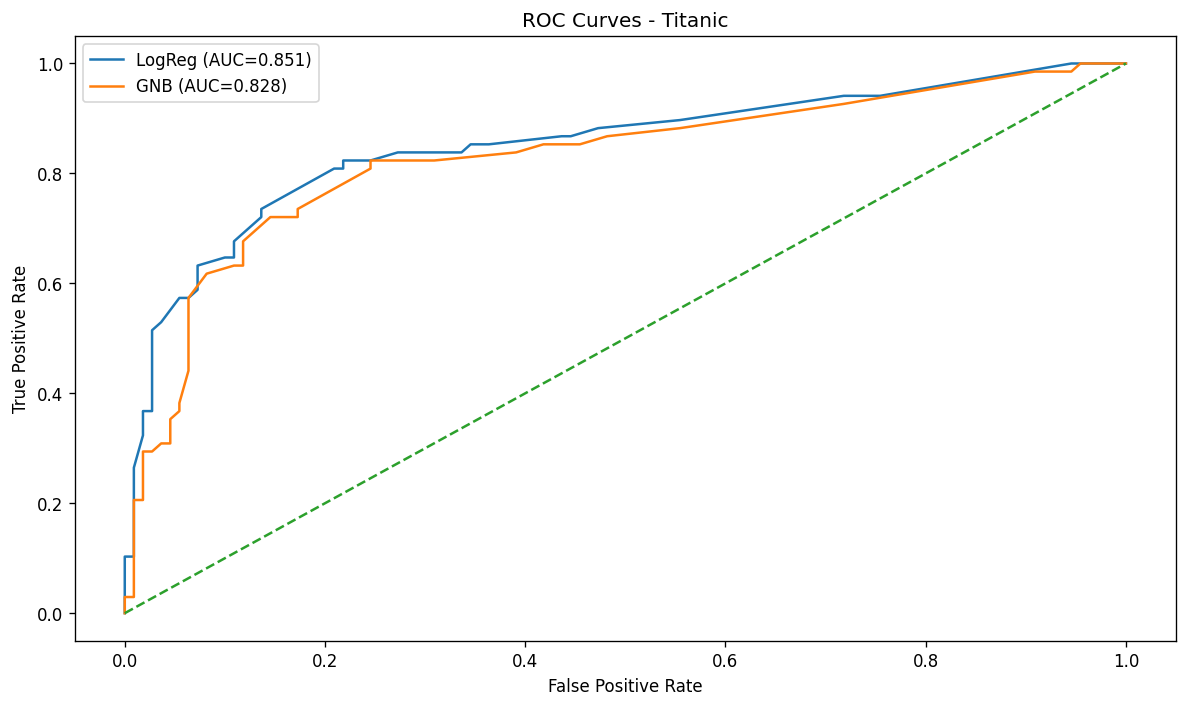

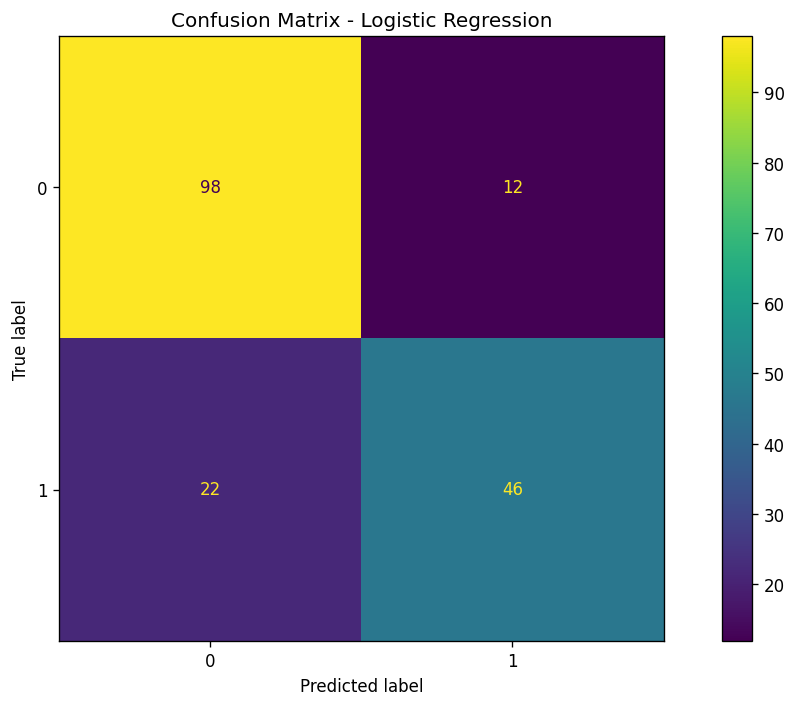

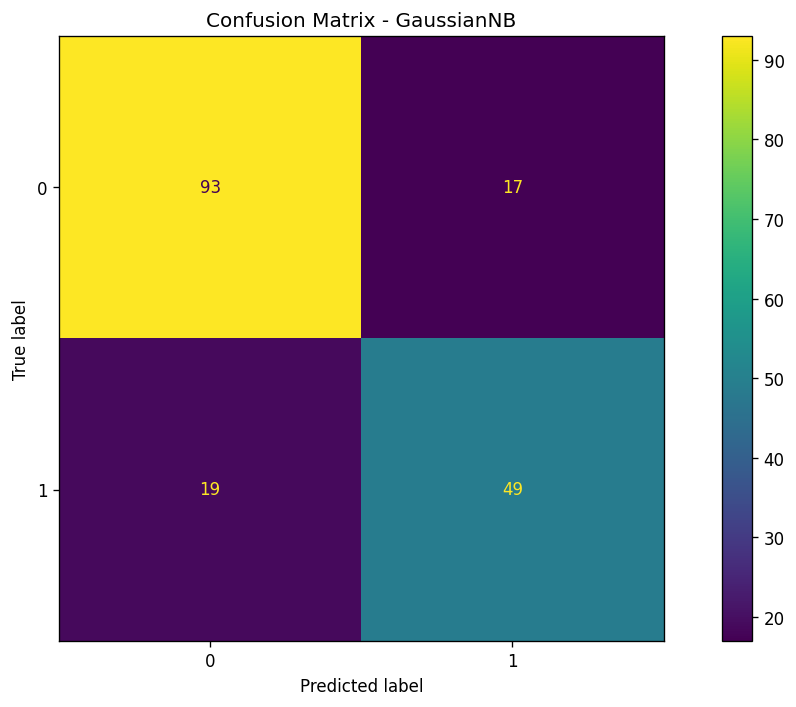

In [19]:
# =========================
# 4) TRAIN MODELS & EVALUATE
# =========================

# --- Fit both pipelines on the training split ---
logreg_clf.fit(X_train, y_train)   # trains: imputation → scaling/one-hot → LogisticRegression
gnb_clf.fit(X_train, y_train)      # trains: imputation → scaling/one-hot → GaussianNB

def evaluate(model, X_tr, y_tr, X_te, y_te):
    """
    Run a consistent evaluation for a fitted classifier 'model'.
    Returns a dict with train/test metrics and the test predictions/probabilities.
    """
    # Hard class predictions (0/1) on train and test
    ytr_pred = model.predict(X_tr)
    yte_pred = model.predict(X_te)

    # Class-1 probabilities (needed for ROC/AUC)
    ytr_proba = model.predict_proba(X_tr)[:, 1]
    yte_proba = model.predict_proba(X_te)[:, 1]

    return {
        # --- Training metrics (spot over/under-fit gaps) ---
        "train": dict(
            accuracy=accuracy_score(y_tr, ytr_pred),
            precision=precision_score(y_tr, ytr_pred, zero_division=0),
            recall=recall_score(y_tr, ytr_pred, zero_division=0),
            f1=f1_score(y_tr, ytr_pred, zero_division=0),
            roc_auc=roc_auc_score(y_tr, ytr_proba),
        ),
        # --- Test metrics (report these) ---
        "test": dict(
            accuracy=accuracy_score(y_te, yte_pred),
            precision=precision_score(y_te, yte_pred, zero_division=0),
            recall=recall_score(y_te, yte_pred, zero_division=0),
            f1=f1_score(y_te, yte_pred, zero_division=0),
            roc_auc=roc_auc_score(y_te, yte_proba),
        ),
        # Keep these for plots and detailed reports
        "y_pred_test": yte_pred,
        "y_proba_test": yte_proba,
    }

# --- Compute metrics for both models ---
log_m = evaluate(logreg_clf, X_train, y_train, X_test, y_test)
gnb_m = evaluate(gnb_clf,    X_train, y_train, X_test, y_test)

# Quick console summary for sanity-checking
print("LogReg (test):", log_m["test"])
print("GNB    (test):", gnb_m["test"])
print("\nClassification report (LogReg):\n",
      classification_report(y_test, log_m["y_pred_test"], digits=3))

# --- ROC curves (comparison) ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_m["y_proba_test"])
fpr_gn, tpr_gn, _ = roc_curve(y_test, gnb_m["y_proba_test"])

plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={log_m['test']['roc_auc']:.3f})")
plt.plot(fpr_gn, tpr_gn, label=f"GNB (AUC={gnb_m['test']['roc_auc']:.3f})")
plt.plot([0, 1], [0, 1], '--')  # random-chance baseline
plt.title("ROC Curves - Titanic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_comparison.png"))
plt.show()

# --- Confusion matrix: Logistic Regression ---
ConfusionMatrixDisplay.from_predictions(y_test, log_m["y_pred_test"])
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_logreg.png"))
plt.show()

# --- Confusion matrix: Gaussian Naive Bayes ---
ConfusionMatrixDisplay.from_predictions(y_test, gnb_m["y_pred_test"])
plt.title("Confusion Matrix - GaussianNB")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_gnb.png"))
plt.show()


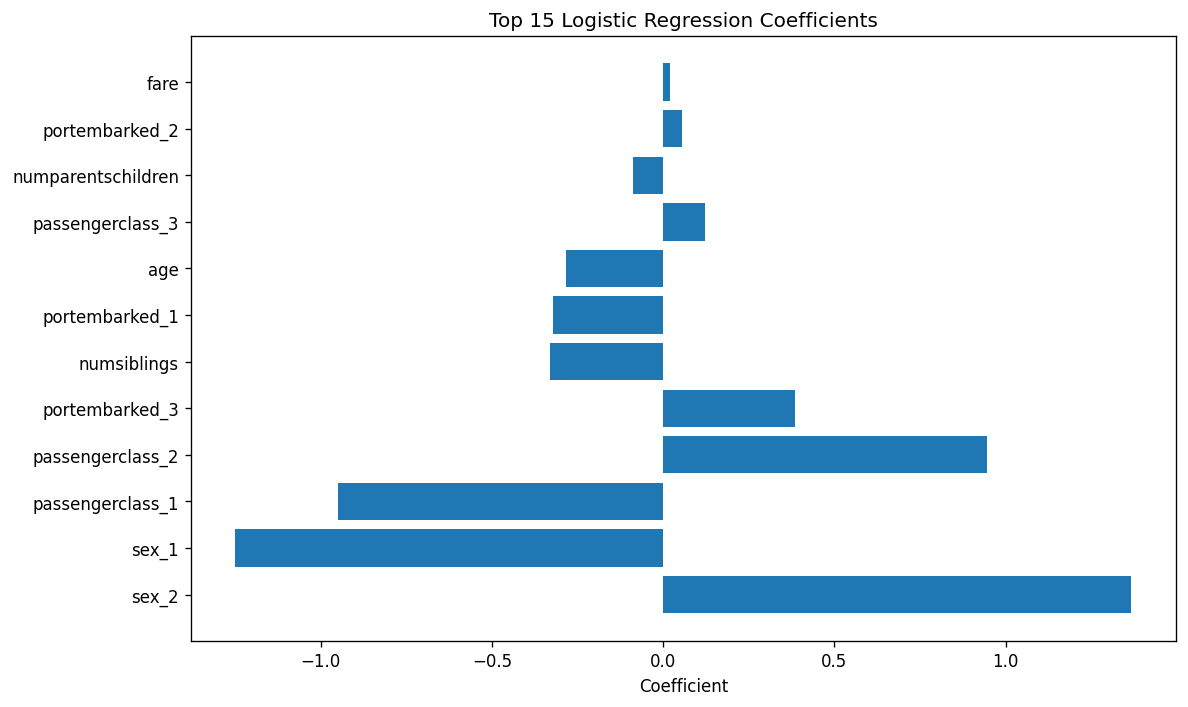

AIC: 656.263, BIC: 701.930
Analysis complete. Outputs saved to: titanic_outputs


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


In [20]:
# =========================================================
# 📌 STEP 5 — ANALYZE & DRAW INFERENCES
#     Extract feature importance, interpret coefficients,
#     compute AIC/BIC using the statsmodels Logit model,
#     and save summary outputs.
# =========================================================

# ---------------------------------------------------------
# Fit preprocessing separately to extract transformed matrix
# ---------------------------------------------------------
# This allows us to:
#   • obtain the exact numeric matrix used by Logistic Regression
#   • extract generated one-hot encoded column names
preprocessor.fit(X_train)
Xtrain_proc = preprocessor.transform(X_train)

# ---------------------------------------------------------
# Build complete feature name list (numeric + encoded categorical)
# ---------------------------------------------------------
cat_names = (
    preprocessor
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(cat_features)
)

feature_names = num_features + list(cat_names)

# ---------------------------------------------------------
# Extract Logistic Regression coefficients for interpretation
# ---------------------------------------------------------
lr = logreg_clf.named_steps['clf']          # actual LogisticRegression estimator
coef = lr.coef_.ravel()                      # flatten coefficient array

# Build a DataFrame for ranking attributes by absolute importance
imp = pd.DataFrame({
    "feature": feature_names,
    "coef": coef,
    "abs": np.abs(coef)
})

# Select top 15 strongest predictors
top15 = imp.sort_values("abs", ascending=False).head(15)

# ---------------------------------------------------------
# Plot top logistic regression coefficients
# ---------------------------------------------------------
# Horizontal bar chart used intentionally for readability.
plt.barh(top15["feature"], top15["coef"])
plt.title("Top 15 Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "logreg_top_coefs.png"))
plt.show()

# ---------------------------------------------------------
# Compute AIC/BIC using statsmodels Logit
# ---------------------------------------------------------
# This reproduces a likelihood-based evaluation of the
# same logistic relationship used above.
#
# Key steps for stability:
#   • add constant term
#   • use L-BFGS optimizer
#   • increase max iterations
#   • disable verbose output
X_sm = sm.add_constant(np.asarray(Xtrain_proc), has_constant='add')
sm_logit = sm.Logit(y_train.values, X_sm)
sm_fit = sm_logit.fit(method='lbfgs', maxiter=500, disp=False)

print(f"AIC: {sm_fit.aic:.3f}, BIC: {sm_fit.bic:.3f}")

# ---------------------------------------------------------
# Save a summary report of results (metrics + AIC/BIC)
# ---------------------------------------------------------
with open(os.path.join(OUT_DIR, "results_summary.txt"), "w") as f:
    f.write("=== Model Metrics (Test) ===\n")
    f.write(
        f"LogReg: Acc={log_m['test']['accuracy']:.3f}, "
        f"Prec={log_m['test']['precision']:.3f}, "
        f"Rec={log_m['test']['recall']:.3f}, "
        f"F1={log_m['test']['f1']:.3f}, "
        f"AUC={log_m['test']['roc_auc']:.3f}\n"
    )
    f.write(
        f"GNB:    Acc={gnb_m['test']['accuracy']:.3f}, "
        f"Prec={gnb_m['test']['precision']:.3f}, "
        f"Rec={gnb_m['test']['recall']:.3f}, "
        f"F1={gnb_m['test']['f1']:.3f}, "
        f"AUC={gnb_m['test']['roc_auc']:.3f}\n\n"
    )
    f.write("=== Logistic Regression (statsmodels) ===\n")
    f.write(f"AIC: {sm_fit.aic:.3f}\nBIC: {sm_fit.bic:.3f}\n")

print("Analysis complete. Outputs saved to:", OUT_DIR)
